# 2017 Stack Overflow Surveys


## Import Data


In [1]:
### Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from ydata_profiling import ProfileReport

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import func
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline

In [2]:
### Load data
survey_df = pd.read_csv('../data/survey-results-public.csv')

## Understand The Data


In [3]:
### Initial EDA with ydata-profiling
#profile = ProfileReport(survey_df, title="Profiling Report")
#profile

In [4]:
### Shape
survey_df.shape

(51392, 154)

In [5]:
### Which Columns have no missing data
survey_df.columns[(survey_df.isnull().sum() == 0)]


Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation'],
      dtype='object')

In [6]:
### Which columns have the most missing data?

# Set threshold for "most" ex) more than 75%
threshold = .75

# Print columns
survey_df.columns[(survey_df.isnull().sum() > threshold*survey_df.shape[0])]


Index(['YearsCodedJobPast', 'WebDeveloperType', 'MobileDeveloperType',
       'NonDeveloperType', 'ExCoderReturn', 'ExCoderNotForMe',
       'ExCoderBalance', 'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills',
       'ExCoderWillNotCode', 'ExCoderActive', 'TimeAfterBootcamp',
       'ExpectedSalary'],
      dtype='object')

In [7]:
# Any duplicates?
survey_df.duplicated().sum()

0

## Initial Business Questions

_(and potential factors of interest)_


**How to enter the field?**
* CousinEducation

**What are Job placement and salary rates for bootcamps?**
* TimeAfterBootcamp

**What factors help predict salary?**
* Many

**What factors help predict job satisfaction?**
*  Many


## Data Exploration


### How to enter the field?


In [8]:
schema = pd.read_csv("../data/survey-results-schema.csv")

In [9]:
### CousinEducation Description
func.get_description("CousinEducation", schema)

86    Let's pretend you have a distant cousin. They ...
Name: Question, dtype: object

In [10]:
### CousinEducation value counts
study = survey_df.CousinEducation.value_counts().reset_index()
study.rename(columns={"CousinEducation":"Method"}, inplace=True)
study

,Method,count
0,Take online courses; Buy books and work throug...,711
1,Take online courses,551
2,None of these,523
3,Take online courses; Part-time/evening courses...,479
4,Take online courses; Bootcamp; Part-time/eveni...,465
...,...,...
730,Master's degree; Contribute to open source; Pa...,1
731,Return to college; Participate in online codin...,1
732,Return to college; Get a job as a QA tester; P...,1
733,Return to college; Participate in hackathons; ...,1


In [11]:
### Get counts for unique study methods
methods = func.separate_values(study, "Method")
methods.sort_values(by="Count", ascending=False, inplace=True)
methods

,Method,Count
0,Take online courses,229
7,Contribute to open source,228
1,Buy books and work through the exercises,226
3,Part-time/evening courses,220
8,Conferences/meet-ups,217
6,Return to college,216
4,Bootcamp,212
10,Participate in online coding competitions,210
11,Participate in hackathons,209
9,Get a job as a QA tester,204


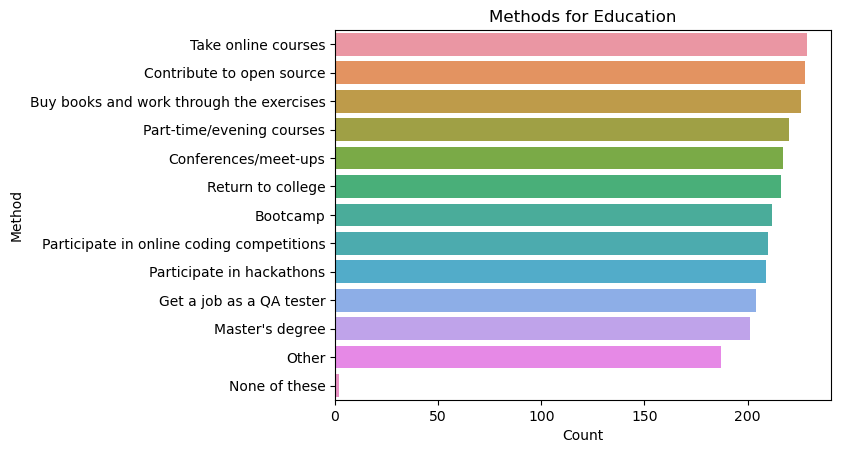

In [12]:
### Bar Plot
sns.barplot(data=methods, y="Method", x="Count")
plt.title("Methods for Education");


> Could people with a degree be biased towards those methods?


In [13]:
### Create boolean column for "HigherEd"
# Define higher ed mapping function
def is_higher_ed(formal_ed_str):
    '''
    INPUT:
        formal_ed_str: string of one of the values in the column "FormalEducation"

    OUTPUT:
        return 1 if the string is in ("Master's degree", "Doctoral", "Professional degree")
        else return 0
    '''

    if formal_ed_str in ("Master's degree", "Doctoral", "Professional degree"):
        return 1
    else:
        return 0

# Create "HigherEd" column 
survey_df["HigherEd"] = survey_df["FormalEducation"].apply(is_higher_ed)

# Check pct higher ed
higher_ed_pct = survey_df["HigherEd"].mean()
print(higher_ed_pct)

0.23069738480697385


In [14]:
### Plot difference in higher ed values across methods

# Subset df to only those with HigherEd of 1
ed_1 = survey_df[survey_df['HigherEd'] == 1]
# Subset df to only those with HigherEd of 0
ed_0 = survey_df[survey_df['HigherEd'] == 0]

# Check higher ed values make sense
print(ed_1.HigherEd.head(2))
print(ed_0.HigherEd.head(2))

# Get proportions for each method count
ed_1_perc = func.get_df_props(ed_1)
ed_0_perc = func.get_df_props(ed_0)

# Merge proportion dataframes and plot
comp_df = ed_1_perc.merge(ed_0_perc, on="Method")
comp_df.columns = ['Method', 'ed_1_perc', 'ed_0_perc']
comp_df['Diff_HigherEd_Vals'] = comp_df['ed_1_perc'] - comp_df['ed_0_perc']
comp_df.style.bar(subset=['Diff_HigherEd_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])

4    1
6    1
Name: HigherEd, dtype: int64
0    0
1    0
Name: HigherEd, dtype: int64


,Method,ed_1_perc,ed_0_perc,Diff_HigherEd_Vals
0,Take online courses,0.108312,0.091687,0.016625
1,Buy books and work through the exercises,0.100252,0.090057,0.010195
2,None of these,0.001008,0.000815,0.000193
3,Part-time/evening courses,0.089673,0.085167,0.004505
4,Bootcamp,0.080605,0.084352,-0.003748
5,Return to college,0.079093,0.085167,-0.006074
6,Contribute to open source,0.100252,0.092095,0.008157
7,Conferences/meet-ups,0.085139,0.085167,-0.000029
8,Other,0.058942,0.069275,-0.010333
9,Get a job as a QA tester,0.072544,0.080685,-0.008141


The highest recommended methods for breaking into data science were taking online courses and contributing to open-source projects. Even individuals that received higher education recommend these methods.


### What are job placement and salary for bootcamp grads?


In [15]:
### Get dataframes with bootcamp participants separated
bootcamp_df = survey_df[survey_df.TimeAfterBootcamp.isnull() == False]
not_bootcamp_df = survey_df[survey_df.TimeAfterBootcamp.isnull() == True]
bootcamp_df.shape

(2602, 155)

In [16]:
### What's the distribution of time from bootcamp to job
print(bootcamp_df["TimeAfterBootcamp"].value_counts()/bootcamp_df.shape[0])

# Remove those who already had a job
no_job = bootcamp_df.query("TimeAfterBootcamp != 'I already had a job as a developer when I started the program'")

print("\n#####\n")
print(no_job["TimeAfterBootcamp"].value_counts()/no_job.shape[0])

TimeAfterBootcamp
I already had a job as a developer when I started the program    0.458493
Immediately upon graduating                                      0.112990
I got a job as a developer before completing the program         0.096849
One to three months                                              0.087625
I haven't gotten a job as a developer yet                        0.081091
Less than a month                                                0.059954
Four to six months                                               0.040354
Longer than a year                                               0.032667
Six months to a year                                             0.029977
Name: count, dtype: float64

#####

TimeAfterBootcamp
Immediately upon graduating                                 0.208659
I got a job as a developer before completing the program    0.178850
One to three months                                         0.161817
I haven't gotten a job as a developer yet              

The 46% of bootcamp grads that already had jobs don't tell us much about how long it takes for bootcamp grads to actually get a job. After removing that, we see that 38% got a job by the end of the program and another 35% had a job within 6 months.


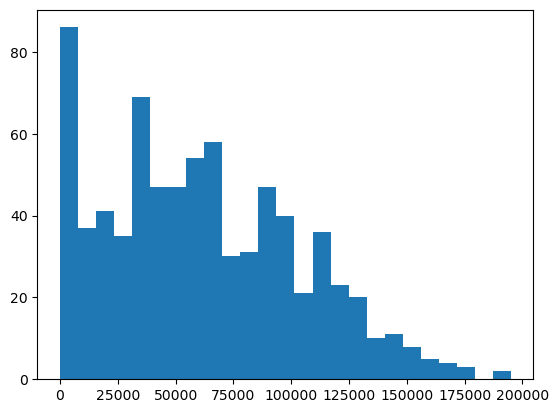

In [17]:
### What is the distribution of salary for bootcamp grads?
plt.hist(data=bootcamp_df, x='Salary', bins=25);

There's a large portion of responses at 0, which could be due to those who haven't found jobs yet. The right-skewed plot is in line with how most jobs taper off at higher incomes. Given how widespread the bootcamp data is, it doesn't seem like we can learn much about salary from it.


### What factors help predict Job Satisfaction?


In [18]:
### Job Satisfaction Descriptive Stats
survey_df.JobSatisfaction.describe()

count    40376.000000
mean         6.957078
std          2.167652
min          0.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: JobSatisfaction, dtype: float64

In [19]:
### Proportion of missing values
survey_df.JobSatisfaction.isnull().mean()

0.21435242839352428

In [20]:
### Which employment groups have the highest job satisfaction?
survey_df.groupby("EmploymentStatus").JobSatisfaction.mean()

EmploymentStatus
Employed full-time                                      6.926805
Employed part-time                                      6.821468
I prefer not to say                                          NaN
Independent contractor, freelancer, or self-employed    7.252823
Not employed, and not looking for work                  7.000000
Not employed, but looking for work                           NaN
Retired                                                      NaN
Name: JobSatisfaction, dtype: float64

The surveyed developers that work for themselves had the highest average job satisfaction 


In [21]:
### Do smaller companies produce higher job satisfaction?
survey_df.groupby("CompanySize").JobSatisfaction.mean().sort_values()

CompanySize
5,000 to 9,999 employees    6.748153
10,000 or more employees    6.810345
I don't know                6.842679
500 to 999 employees        6.883661
1,000 to 4,999 employees    6.884509
100 to 499 employees        6.937089
20 to 99 employees          6.949092
10 to 19 employees          7.000799
Fewer than 10 employees     7.008749
I prefer not to answer      7.280835
Name: JobSatisfaction, dtype: float64

Smaller companies did have higher average job satisfaction scores.


In [22]:
### Does remote work have an impact on job satisfaction?
survey_df.groupby("HomeRemote").JobSatisfaction.mean().sort_values()

HomeRemote
Never                                                      6.632502
It's complicated                                           6.840830
More than half, but not all, the time                      6.953184
About half the time                                        6.973702
A few days each month                                      7.077509
Less than half the time, but at least one day each week    7.120125
All or almost all the time (I'm full-time remote)          7.388430
Name: JobSatisfaction, dtype: float64

The highest average always work remote and the lowest average never worked remote, with a mixed range inbetween.

In [23]:
### Does having more schooling impact job satisfaction?
survey_df.groupby("FormalEducation").JobSatisfaction.mean().sort_values()

FormalEducation
I never completed any formal education                               6.833333
Bachelor's degree                                                    6.866363
Master's degree                                                      6.953151
Primary/elementary school                                            6.956897
I prefer not to answer                                               7.005682
Some college/university study without earning a bachelor's degree    7.081334
Professional degree                                                  7.087459
Secondary school                                                     7.143082
Doctoral degree                                                      7.348857
Name: JobSatisfaction, dtype: float64

Those with doctoral degrees had the highest avergage job satisfaction.

## Predicting Salary

In [24]:
### Create linear regression model with numeric vars
num_vars = survey_df.copy()[["Salary", "CareerSatisfaction", "HoursPerWeek", "JobSatisfaction", "StackOverflowSatisfaction"]]

### Fix missing values in numerical variables
# remove rows with missing salary
num_vars.dropna(subset=["Salary"], axis=0, inplace=True)

# Fill other NaN values with mean
fill_mean = lambda col: col.fillna(col.mean())
num_vars = num_vars.apply(fill_mean)

# Linear Model
X = num_vars[["CareerSatisfaction", "HoursPerWeek", "JobSatisfaction", "StackOverflowSatisfaction"]]
y = num_vars[["Salary"]]
reg, X_train, X_test, y_train, y_test = \
    func.create_linear_mod(X, y)

# Score model
score = reg.score(X_test, y_test)
print("r-squared score using quantitative variables was {} on {} values".format(score, X_train.shape[0]))

r-squared score using quantitative variables was 0.04072431792894726 on 9023 values


In [25]:
### Create linear regression model with all vars
# Pull a list of the column names of the categorical variables
cat_df = survey_df.select_dtypes(include=['object'])
cat_cols = cat_df.columns

# Clean df
X, y = func.clean_data(survey_df.sample(20000, random_state=42), "Salary", cat_cols, dummy_na=False)

# Create linear regression model with catagorical vars
reg, X_train, X_test, y_train, y_test = \
    func.create_linear_mod(X, y)

# Scores
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)

print("r-squared training score using Catagorical & Numerical variables was {} on {} values".format(train_score, X_train.shape[0]))
print("r-squared test score using Catagorical & Numerical variables was {} on {} values".format(test_score, X_train.shape[0]))

r-squared training score using Catagorical & Numerical variables was 1.0 on 3567 values
r-squared test score using Catagorical & Numerical variables was 0.4649812441787491 on 3567 values


{'5000': 0.032698458333382696, '3500': 0.0682110562838445, '2500': 0.09473544084003516, '1000': 0.587206164566722, '100': 0.6671884831621534, '50': 0.7058385790293293, '25': 0.6832791583744777}


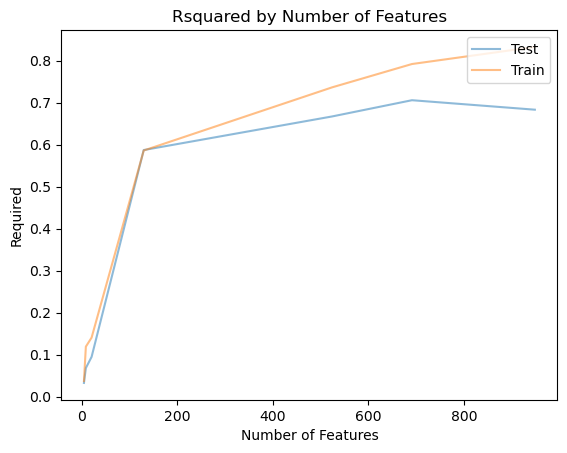

r-squared training score on optimal feature set was 1.0 on 3567 values using 50 as a cutoff
r-squared test score on optimal feature set was 0.4649812441787491 on 3567 values using 50 as a cutoff


In [26]:
### Select features with cutoffs
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 25]

best_cutoff, scores_test, scores_train, reg, X_train, X_test, y_train, y_test = \
    func.find_optimal_feature_cutoff(X, y, cutoffs, plot=True)

print("r-squared training score on optimal feature set was {} on {} values using {} as a cutoff".format(train_score, X_train.shape[0], best_cutoff))
print("r-squared test score on optimal feature set was {} on {} values using {} as a cutoff".format(test_score, X_train.shape[0], best_cutoff))

**Which features had the greatest impact on salary?**

The default penalty on coefficients using linear regression in sklearn is a ridge (also known as an L2) penalty. Because of this penalty, and that all the variables were normalized by default, we can look at the size of the coefficients in the model as an indication of the impact of each variable on the salary. The larger the coefficient, the larger the expected impact on salary.

In [27]:
### Get feature coefficients
coef_df = func.coef_weights(reg.coef_, X_train)

# Top results
coef_df.head(20)

,est_int,coefs,abs_coefs
25,Country_United States,55760.755666,55760.755666
11,Country_Brazil,45181.245801,45181.245801
301,Currency_Brazilian reais (R$),-44396.894402,44396.894402
12,Country_Canada,39715.028155,39715.028155
23,Country_Switzerland,38669.810404,38669.810404
9,Country_Australia,34147.834368,34147.834368
16,Country_Israel,30318.675209,30318.675209
306,Currency_Polish zloty (zl),-26137.244671,26137.244671
309,Currency_Swiss francs,24977.219886,24977.219886
308,Currency_Swedish kroner (SEK),22112.808861,22112.808861


Based on the coefficients, it appears country and years of experience had the greatest impact on salary. There were also several currency features which I would guess have multicollinearity with country and we could look into removing. Overall, it makes sense that these would be important features in predicting salary.